# Estimating orbital parameters with scintools

In this tutorial we will see how to use scintools to determine the orbital parameters of pulsars in binary systems from scintillation observations. The first part covers the use of variations in the autocorrelation function, while the second part covers the use of scintillation arc curvature variations.

## ACF variations

In this section we will use scintools to model variations in the interstellar scintillation velocity, $V_{\rm ISS}$, to obtain estimates for the orbital parameters of a binary pulsar and parameters of the scattering medium.

We start by importing the necessary modules.

In [82]:
import sys
sys.path.insert(0,
    '/home/kris/Documents/research/scintillation_project/scintools/scintools')
from scint_utils import read_results, float_array_from_dict, read_par, get_earth_velocity, pars_to_params, \
    get_true_anomaly
import numpy as np
import matplotlib.pyplot as plt

We will aim to reproduce the results of [Reardon *et al.* (2019)](https://doi.org/10.1093/mnras/stz643) for PSR J1141$-$6545, a relativistic binary pulsar in a 4.7 hour eccentric orbit with a white dwarf companion. Due to relativistic effects, J1141$-$6545's longitude of periastron, $\omega$, is undergoing a non-trivial precession that must be accounted for. These measured parameters, as well as others such as RA and Dec coordinates, eccentricity, period, etc. can be read in from a parameter file in the standard $\text{TEMPO2}$ format using `read_par`:

In [83]:
pars = read_par('J1141-6545.par')

Next, we read in the data. The file below contains measurements and uncertainties of the decorrelation bandwidth, $\Delta\nu_{\rm d}$, and scintillation timescale, $\tau_{\rm d}$, for ~1,600 observations of J1141$-$6545. How to measure these parameters from autocorrelation functions using scintools is described in the ACF modelling tutorial.

Datafiles in the scintools format can be read in using `read_results`, which creates a dictionary of arrays:

In [84]:
data = read_results('J1141-6545.dat')

In [85]:
# converting data array entries to floats
mjd = float_array_from_dict(data, 'mjd')
freq = float_array_from_dict(data, 'freq')
dnu, dnuerr = float_array_from_dict(data, 'dnu'), float_array_from_dict(data, 'dnuerr')
tau, tauerr = float_array_from_dict(data, 'tau'), float_array_from_dict(data, 'tauerr')

Our goal here is to model the scintillation velocity, $V_{\rm ISS}$, which is related to the ACF parameters by $$V_{\rm ISS}=A_{\rm ISS}\frac{\sqrt{D\Delta\nu_{\rm d}}}{f\tau_{\rm d}},\tag*{(1)}$$ where $D$ is the distance to the pulsar in kiloparsecs, $f$ is the observing frequency in GHz, $\Delta\nu_{\rm d}$ is in MHz, and $\tau_{\rm d}$ is in seconds. The factor $A_{\rm ISS}$ is equal to $2.53\times 10^4\,\text{km}\,\text{s}^{-1}$ for a uniform scattering medium and $2.78\times 10^4\sqrt{2(1-s)/s}\,\text{km}\,\text{s}^{-1}$ for a thin screen at fractional distance $s=1-D_{\rm screen}/D$.

Equation 1 is modelled through the effective velocity, given by $$\boldsymbol{V}_{\rm eff}=(1-s)(\boldsymbol{V}_{\rm p}+\boldsymbol{V}_\mu)+s\boldsymbol{V}_\oplus-\boldsymbol{V}_{\rm ISM},\tag*{(2)}$$ where $\boldsymbol{V}_{\rm p}$, $\boldsymbol{V}_\mu$, $\boldsymbol{V}_\oplus$, and $\boldsymbol{V}_{\rm ISM}$ are the pulsar orbital velocity, the pulsar proper motion, the Earth velocity, and the ISM velocity, respectively. The scintillation velocity is then $$V_{\rm ISS}^{\rm model}=\frac{1}{s}\sqrt{aV_{\rm{eff},\delta}^2+bV_{\rm{eff},\alpha}^2+cV_{\rm{eff},\delta}V_{\rm{eff},\alpha}},\tag*{(3)}$$ where $V_{\rm{eff},\alpha}$ and $V_{\rm{eff},\delta}$ are the RA and Dec components of $\boldsymbol{V}_{\rm eff}$ and, for an anisotropic scattering screen,
\begin{align}
a&=\frac{1-R\cos(2\psi)}{\sqrt{1-R^2}}\tag*{(4.1)}\\
b&=\frac{1+R\cos(2\psi)}{\sqrt{1-R^2}}\tag*{(4.2)}\\
c&=\frac{-2R\sin(2\psi)}{\sqrt{1-R^2}}\tag*{(4.3)}
\end{align}
where $R$ is the axial ratio of the scattering screen and $\psi$ is the angle of the major axis as measured east from the dec axis. Otherwise, for an isotropic screen, we simply have $a=1,b=1,c=0$.

However, in general $s$, $D$ and the numerical factor of $A_{\rm ISS}$ that appear in Equation 1 will not be known *a priori*. We therefore model instead the "empirical" scintillation velocity: $$\tilde{V}_{\rm ISS}=\frac{\sqrt{\Delta\nu_{\rm d}}}{f\tau_{\rm d}},\tag*{(5)}$$ which for a thin scattering screen is modelled by $$\tilde{V}_{\rm ISS}^{\rm model}\frac{\kappa}{\sqrt{2D(1-s)/s}}V_{\rm ISS}^{\rm model},\tag*{(6)}$$ where $\kappa$ is the numerical factor in $A_{\rm ISS}$.

So let's see what $\tilde{V}_{\rm ISS}$ looks like for our data whe plotted against orbital phase. For the true anomaly at each observation MJD we use `get_true_anomaly`, which requires a time of periastron, the period (and its derivative if available), and the eccentricity. We much also account for the change in periastron angle.

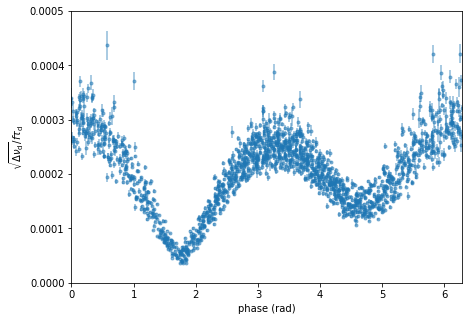

In [86]:
# orbital phase
true_anomaly = get_true_anomaly(mjd, pars).squeeze()
deltaOM = (pars['OMDOT'] * np.pi / 180) * (mjd - pars['T0']) / 365.2422  # change in periastron with time
phase = true_anomaly + deltaOM

# "empirical" scintillation velocity
viss = np.sqrt(dnu) / (freq * tau)
visserr = np.sqrt((dnuerr / (2 * tau * np.sqrt(dnu)))**2 + (tauerr * np.sqrt(dnu) / tau**2)**2) / freq

f = plt.subplots(figsize=(7,5))
f[1].errorbar(phase % (2 * np.pi), viss, visserr, marker='.', linestyle='', alpha=0.5)
f[1].set_xlabel('phase (rad)')
f[1].set_ylabel(r'$\sqrt{\Delta\nu_{\rm d}}/f\tau_{\rm d}$')
f[1].set_xlim(0, 2*np.pi)
f[1].set_ylim(0, 5e-4)
plt.show()

We now set up the model. How this is done will depend on what parameters are already known *a priori* and/or what simplifying assumptions one would like to use. Already at this point we have the true anomly $\theta$, which factors into the pulsar orbital velocity:
\begin{align}
V_{\rm{p},\parallel}&=-V_0(e\sin\omega + \sin(\theta+\omega))\tag{7.1}\\
V_{\rm{p},\perp}&=V_0\cos i(e\cos\omega + \cos(\theta+\omega))\tag{7.2},
\end{align}
which are related to the RA and Dec components through the longitude of ascending node $\Omega$:
$$
\begin{pmatrix}
    V_{\rm{p},\alpha}\\
    V_{\rm{p},\delta}
\end{pmatrix}=\begin{pmatrix}
    \sin\Omega & \cos\Omega\\
    \cos\Omega & -\sin\Omega
\end{pmatrix}\begin{pmatrix}
    V_{\rm{p},\parallel}\\
    V_{\rm{p},\perp}
\end{pmatrix}\tag{8}.
$$
Furthermore, we can calculate the Earth velocity $\boldsymbol{V}_\oplus$ at each observation MJD from the pulsar RA,Dec coordinates:

In [87]:
vearth_ra, vearth_dec = get_earth_velocity(mjd, pars['RAJ'], pars['DECJ'])
vearth_ra = vearth_ra.squeeze()
vearth_dec = vearth_dec.squeeze()

The remaining model parameters are to be determined from the fit. We opt here to use the MCMC functionality of `lmfit`'s `Minimizer` class for this, but in principle any minimization code can be used.

We start by converting our pars dictionary to an `lmfit` `Parameters` object using `pars_to_params`. We then add the priors for the parameters we want to fit:

In [88]:
from lmfit import Minimizer

params = pars_to_params(pars)
params.add('s',        value=np.random.uniform(low=0, high=1),   min=0, max=1)
params.add('d',        value=np.random.normal(loc=12, scale=6),  min=0, max=20)
params.add('psi',      value=np.random.uniform(low=0, high=180), min=0, max=180)
params.add('vism_ra',  value=np.random.normal(loc=0, scale=20),  min=-200, max=200)
params.add('vism_dec', value=np.random.normal(loc=0, scale=20),  min=-200, max=200)
params.add('COSI',     value=np.random.uniform(low=-1, high=1),  min=-1, max=1)
params.add('KOM',      value=np.random.uniform(low=0, high=360), min=0, max=360)
params.add('R',        value=np.random.uniform(low=0, high=1),   min=0, max=1)
params.add('kappa',    value=np.random.uniform(low=0, high=10),  min=0, max=10)

The model (Equation 6) is implemented in the function `veff_thin_screen`, which returns the weighted residuals. In addition to the parameters, the function takes in the data, weights (which here we take as 1/error), true anomaly, and Earth velocity. These are specified with the `fcn_args` parameter of `Minimizer`.

In [89]:
from scint_models import veff_thin_screen

args = (viss, 1/visserr, true_anomaly, vearth_ra, vearth_dec, mjd)
func = Minimizer(veff_thin_screen, params, fcn_args=args)

Without further ado, let's run the fit:

In [90]:
results = func.emcee(nwalkers=1000, steps=1000,
                          burn=200, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:58<00:00,  1.14s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [120.19800943  77.66588752 128.03745157 139.58200598 138.59743138
  69.92683545 108.30443019  96.97896386  58.989756  ]


The estimates for the parameters can be displayed with a corner plot of the marginalized posteriors:

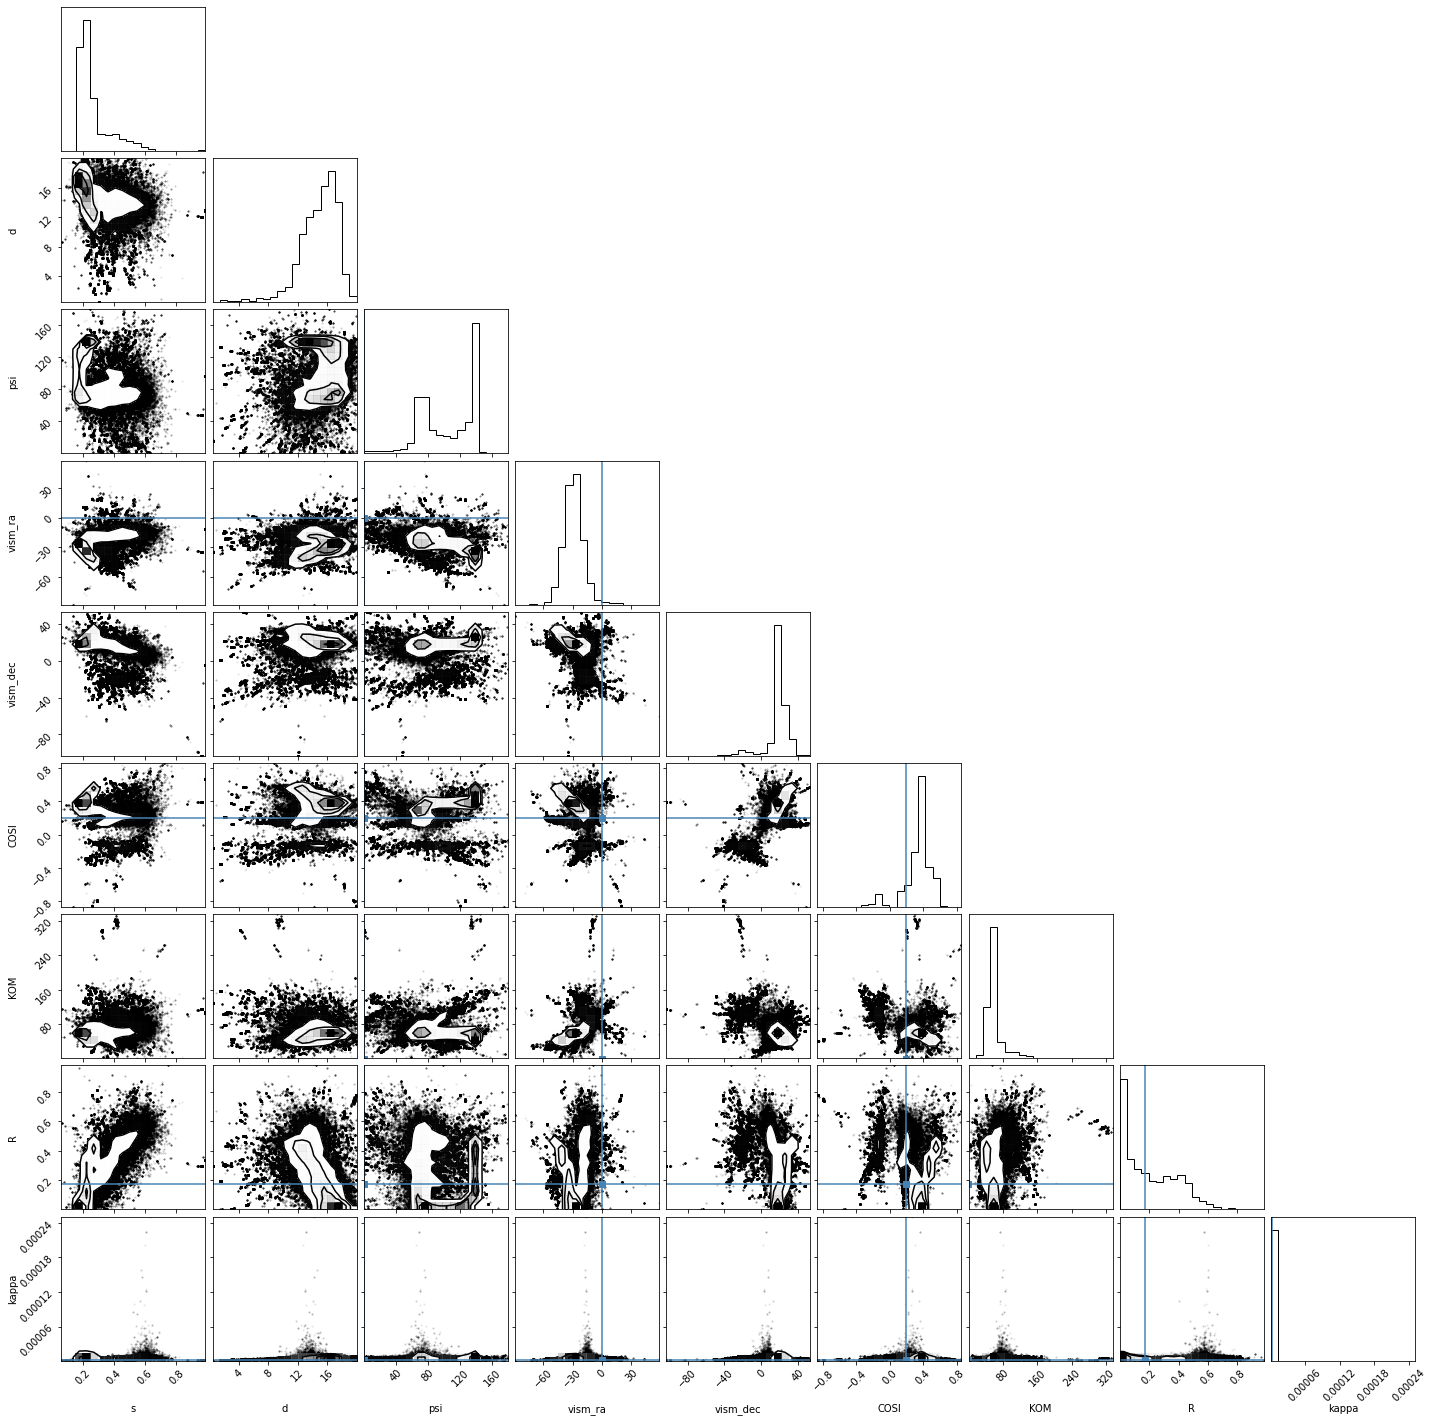

In [91]:
import corner

corner_plot = corner.corner(results.flatchain, labels=results.var_names,
                             truths=list(results.params.valuesdict().values()))

Let's see how the model compares to the data, this time plotting the actual scintillation velocity: 

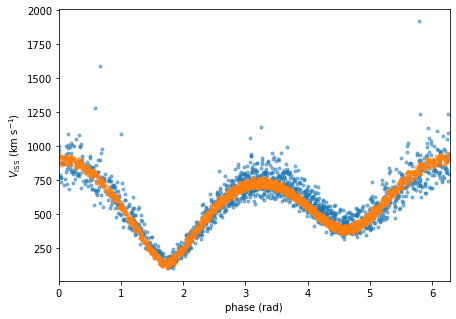

In [92]:
d, derr = results.params['d'].value, results.params['d'].stderr
s, serr = results.params['s'].value, results.params['s'].stderr
kappa, kappaerr = results.params['kappa'].value, results.params['kappa'].stderr
coeff = np.sqrt(2 * d * (1 - s) / s) / kappa  # conversion factor from "empirical" to true velocity

coefferr = (coeff / 2) * np.sqrt((derr / d)**2 + (serr / (s * (1 - s)))**2)
#visserr = np.sqrt((coeff * visserr)**2 + (viss * coefferr)**2)

model = -veff_thin_screen(results.params, np.zeros(np.shape(mjd)), np.ones(np.shape(mjd)), true_anomaly,
                     vearth_ra, vearth_dec, mjd)
model *= coeff
viss *= coeff

f = plt.subplots(figsize=(7,5))
f[1].errorbar(phase % (2*np.pi), viss, visserr, marker='.', linestyle='', alpha=0.5, zorder=0, label='data')
f[1].scatter(phase % (2*np.pi), model, color='C1', marker='.', alpha=0.5, zorder=1, label='model')
f[1].set_xlabel('phase (rad)')
f[1].set_ylabel(r'$V_{\rm ISS}$ (km s$^{-1}$)')
f[1].set_xlim(0, 2*np.pi)
#f[1].set_ylim(0, 5e-4)
plt.show()

## Arc curvature variations

In this section we will see how to use variations in the scintillation arc curvature to estimate orbital parameters of a binary pulsar and properties of the scattering medium. This section is self-contained, though most steps are similar to those in the previous section on ACF variations.

We start by importing the necessary modules:

In [35]:
import sys
sys.path.insert(0,
    '/home/kris/Documents/research/scintillation_project/scintools/scintools')
from scint_utils import read_results, float_array_from_dict, read_par, get_earth_velocity, pars_to_params, \
    get_true_anomaly
import numpy as np
import matplotlib.pyplot as plt

We will aim to reproduce the results of [Reardon *et al.* (2020)](https://doi.org/10.3847/1538-4357/abbd40) for the binary millisecond pulsar J0437$-$4715. The measured parameters of the pulsar, such as RA and Dec coordinates, eccentricity, period, etc. can be read in from a parameter file in the standard $\text{TEMPO2}$ format using `read_par`:

In [36]:
pars = read_par('J0437-4715.par')

Next, we read in the data. The file below contains scintillation arc curvature measurements and uncertainties for ~4,800 observations of J0437$-$4715. How to measure arc curvatures from secondary spectra using scintools is described in the arc modelling tutorial.

Datafiles in the scintools format can be read in using `read_results`, which creates a dictionary of arrays:

In [37]:
data = read_results('J0437-4715.dat')

In [38]:
# converting data array entries to floats
mjd = float_array_from_dict(data, 'mjd')
freq = float_array_from_dict(data, 'freq')
eta, etaerr = float_array_from_dict(data, 'betaeta'), float_array_from_dict(data, 'betaetaerr')

Let's see what this looks like as a function of time:

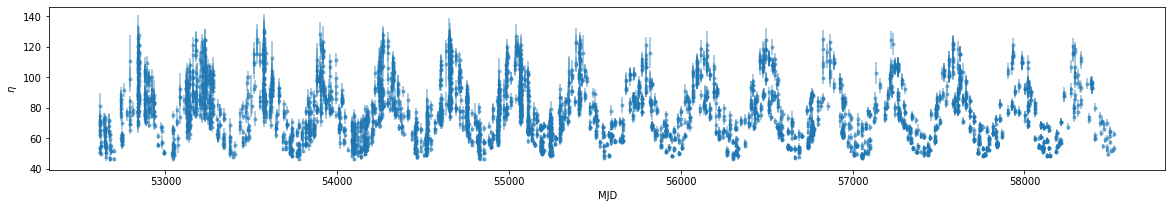

In [39]:
f = plt.subplots(figsize=(20,3))
f[1].errorbar(mjd, eta, etaerr, marker='.', linestyle='', alpha=0.5)
f[1].set_xlabel('MJD')
f[1].set_ylabel(r'$\eta$')
plt.show()

Our goal is to model variations in the arc curvature with $$\eta=\frac{Ds(1-s)}{2(\boldsymbol{V}_{\rm eff}\cdot\hat{\boldsymbol{\rho}})}^2,\tag{9}$$ where $D$ is the distance to the pulsar, $s=1-D_{\rm screen}/D$ is the fractional screen distance, $\boldsymbol{V}_{\rm eff}$ is the effective velocity, and $\hat{\boldsymbol{\rho}}$ is the unit vector in the direction of the major axis of the anisotropic scattering screen, which we parametrize by angle $\psi$ it makes east from the declination axis: $$\hat{\boldsymbol{\rho}}=\begin{pmatrix}\rho_\alpha\\\rho_\delta\end{pmatrix}=\begin{pmatrix}\sin\psi\\\cos\psi\end{pmatrix}.\tag{10}$$ The effective velocity is given by $$\boldsymbol{V}_{\rm eff}=(1-s)(\boldsymbol{V}_{\rm p}+\boldsymbol{V}_\mu)+s\boldsymbol{V}_\oplus-\boldsymbol{V}_{\rm ISM},\tag{11}$$ where $\boldsymbol{V}_{\rm p}$, $\boldsymbol{V}_\mu$, $\boldsymbol{V}_\oplus$, and $\boldsymbol{V}_{\rm ISM}$ are the pulsar orbital velocity, the pulsar proper motion, the Earth velocity, and the ISM velocity, respectively. At this point, we can readily compute $\boldsymbol{V}_\oplus$ at each observation MJD from the pulsar RA,Dec coordinates:

In [40]:
vearth_ra, vearth_dec = get_earth_velocity(mjd, pars['RAJ'], pars['DECJ'])
vearth_ra = vearth_ra.squeeze()
vearth_dec = vearth_dec.squeeze()

We can also calculate the true anomaly $\theta$, which factors into the pulsar orbital velocity:
\begin{align}
V_{\rm{p},\parallel}&=-V_0(e\sin\omega + \sin(\theta+\omega))\tag{12.1}\\
V_{\rm{p},\perp}&=V_0\cos i(e\cos\omega + \cos(\theta+\omega))\tag{12.2},
\end{align}
which are related to the RA and Dec components through the longitude of ascending node $\Omega$:
$$
\begin{pmatrix}
    V_{\rm{p},\alpha}\\
    V_{\rm{p},\delta}
\end{pmatrix}=\begin{pmatrix}
    \sin\Omega & \cos\Omega\\
    \cos\Omega & -\sin\Omega
\end{pmatrix}\begin{pmatrix}
    V_{\rm{p},\parallel}\\
    V_{\rm{p},\perp}
\end{pmatrix}\tag{13}.
$$

In [41]:
true_anomaly = get_true_anomaly(mjd, pars).squeeze()

Assuming circular orbit for true anomaly calculation


The rest of the unknown parameters are to be determined from the fit. For this we opt to use the MCMC functionality of `lmfit`'s `Minimizer` class for this, but in principle any minimization code can be used.

We start by converting our pars dictionary to an `lmfit` `Parameters` object using `pars_to_params`. We then add the priors for the parameters we want to fit. Since J0437$-$4715's distance is precisely known, we've added it in as a fixed value. 

In [42]:
from lmfit import Minimizer

params = pars_to_params(pars)
params.add('d',         value=0.15679, vary=False)
params.add('s',         value=np.random.uniform(low=0, high=1),   min=0, max=1)
params.add('zeta',      value=np.random.uniform(low=0, high=180), min=0, max=180)
params.add('vism_zeta', value=np.random.normal(loc=0, scale=20),  min=-200, max=200)
params.add('COSI',      value=np.random.uniform(low=-1, high=1),  min=-1, max=1)
params.add('KOM',       value=np.random.uniform(low=0, high=360), min=0, max=360)

The model (Equation 10) is implemented in the function `arc_curvature`, which returns the weighted residuals. In addition to the parameters, the function takes in the data, weights (which here we take as 1/error), true anomaly, and Earth velocity. These are specified with the `fcn_args` parameter of `Minimizer`.

In [43]:
from scint_models import arc_curvature

args = (eta, 1/etaerr, true_anomaly, vearth_ra, vearth_dec, mjd)
func = Minimizer(arc_curvature, params, fcn_args=args)

All that remains is to run the fit:

In [44]:
results = func.emcee(nwalkers=1000, steps=1000,
                          burn=200, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:49<00:00,  2.13it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 59.87415664  86.42718166 124.18265479 119.16640787  41.41005108]


The estimates for the parameters can be displayed with a corner plot of the marginalized posteriors:

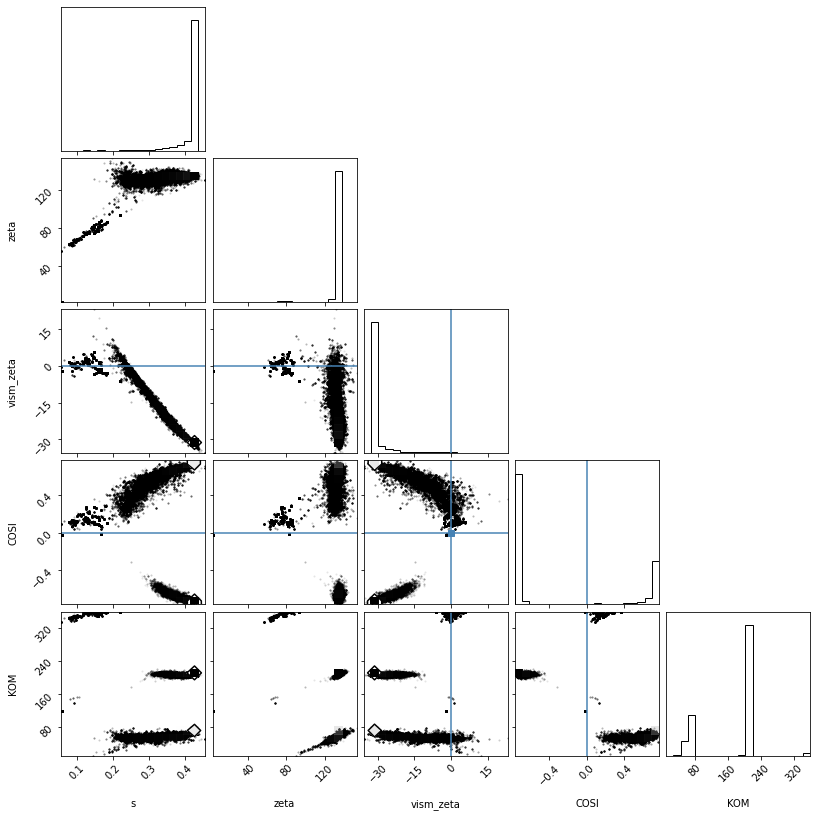

In [45]:
import corner

corner_plot = corner.corner(results.flatchain, labels=results.var_names,
                             truths=list(results.params.valuesdict().values()))

Let's see how the model compares to the data

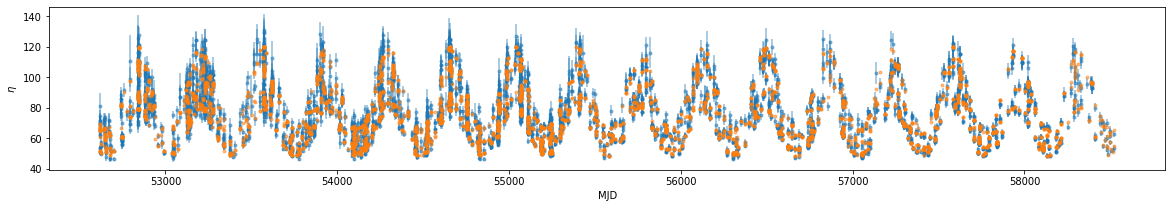

In [46]:
model = -arc_curvature(results.params, np.zeros(np.shape(mjd)), np.ones(np.shape(mjd)), true_anomaly,
                     vearth_ra, vearth_dec, mjd)

f = plt.subplots(figsize=(20,3))
f[1].errorbar(mjd, eta, etaerr, marker='.', linestyle='', alpha=0.5, zorder=0)
f[1].scatter(mjd, model, marker='.', color='C1', alpha=0.5, zorder=1)
f[1].set_xlabel('MJD')
f[1].set_ylabel(r'$\eta$')
plt.show()

We can also now plot the orbital component on its own.

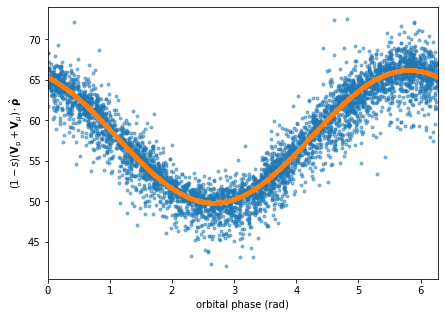

In [52]:
from scint_models import effective_velocity_annual

kmpkpc = 3.085677581e16
d = results.params['d'].value
s = results.params['s'].value
zeta = results.params['zeta'].value * np.pi / 180
vism_zeta = results.params['vism_zeta'].value

veff_model = effective_velocity_annual(results.params, true_anomaly, np.zeros(np.shape(mjd)),
                                       np.zeros(np.shape(mjd)), mjd) # veff model without Earth velocity
veff_proj_model = veff_model[0] * np.sin(zeta) + veff_model[1] * np.cos(zeta) # projected onto anisotropy
veff_proj =  np.sqrt(d * kmpkpc * s * (1 - s) / (2e9 * eta)) # projected veff data
veff_proj -= s * (vearth_ra * np.sin(zeta) +
                  vearth_dec * np.cos(zeta)) - vism_zeta # subtract Earth & ISM velocity

phase = (true_anomaly + (pars['OMDOT'] * np.pi / 180) * (mjd - pars['T0']) / 365.2422) % (2 * np.pi)
f = plt.subplots(figsize=(7,5))
f[1].errorbar(phase, veff_proj, np.zeros(np.shape(etaerr)), marker='.', linestyle='', alpha=0.5, zorder=0)
f[1].scatter(phase, veff_proj_model, marker='.', color='C1', alpha=0.5, zorder=1)
f[1].set_xlabel('orbital phase (rad)')
f[1].set_ylabel(r'$(1-s)(\mathbf{V}_{\rm p}+\mathbf{V}_\mu)\cdot\hat{\mathbf{\rho}}$')
f[1].set_xlim(0, 2*np.pi)
plt.show()